In [1]:
import keras
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:

df = pd.read_csv('./fake_or_real_news.csv')
df['merged_text'] = df['title'] + '. ' + df['text']
df.loc[df['label'] == 'REAL', 'target'] = 0
df.loc[df['label'] == 'FAKE', 'target'] = 1
df.head()
df_pick = df[['merged_text', 'target']]

1. Load data as train and test data.   
  a. add Title to text and create final text, label ordered pair.  
  b. Split 80-20 into train and test datasets.

In [4]:
training_data = df_pick.sample(frac=0.8, random_state=25)
testing_data = df_pick.drop(training_data.index)

print(training_data.shape)
print(testing_data.shape)

(5068, 2)
(1267, 2)


In [5]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_data['merged_text'].values, tf.string),
            tf.cast(training_data['target'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(testing_data['merged_text'].values, tf.string),
            tf.cast(testing_data['target'].values, tf.int32)
        )
    )
)
BUFFER_SIZE = 10000
BATCH_SIZE = 4
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2022-04-10 10:50:41.579624: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-10 10:50:43.461586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10788 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:88:00.0, compute capability: 3.7


In [6]:
for example, label in training_dataset.take(1):
  print('texts: ', example.numpy()[:1])
  print('labels: ', label.numpy()[:1])

texts:  [b'Culture War \xe2\x80\x93 The \xe2\x80\x98Have Mores\xe2\x80\x99 Mock DAPL Protectors for Halloween. Waking Times \nMore evidence emerges that a culture war, or class war, is brewing between the 99% and the 1%, between the \xe2\x80\x98Have-Mores\xe2\x80\x99 and the \xe2\x80\x98Have-Nots.\xe2\x80\x99 Or, more truthfully between the middle and lower socio-economic classes who are forced to follow the law and pay taxes, and the elite who are allowed to be absolutely lawless and ruthless in their accumulation of wealth and privilege. \nIn a speech in 2000 at the Al Smith Dinner for charity , the same event that recently hosted presidential candidates Trump and Clinton together, former President George W. Bush reminded us who the political elite works for in this nation, and in the world at large. \n\xe2\x80\x9cThis is an impressive crowd. The haves and the have mores. Some people call you the elite. I call you my base\xe2\x80\x9d ~George W. Bush \nThis sort of trickle-down mental

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(training_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is',
       'for', 'on', 'as', 'it', 'with', 'he', 'was', 'are', 'be', 'this'],
      dtype='<U14')

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 136,  94, ..., 868,   5,   1],
       [  1, 720,   1, ...,   0,   0,   0],
       [ 51,   1,   1, ...,   0,   0,   0]])

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

2022-04-10 10:51:39.295071: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


[0.00307037]


In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [14]:
history = model.fit(training_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=1)

Epoch 1/10
1267/1267 [==============================] - 156s 123ms/step - loss: 0.6325 - accuracy: 0.5852 - val_loss: 0.7011 - val_accuracy: 1.0000
Epoch 2/10
1267/1267 [==============================] - 150s 119ms/step - loss: 0.4651 - accuracy: 0.7930 - val_loss: 0.0625 - val_accuracy: 1.0000
Epoch 3/10
1267/1267 [==============================] - 150s 119ms/step - loss: 0.3567 - accuracy: 0.8619 - val_loss: 0.0538 - val_accuracy: 1.0000
Epoch 4/10
1267/1267 [==============================] - 153s 120ms/step - loss: 0.2965 - accuracy: 0.8875 - val_loss: 0.0830 - val_accuracy: 1.0000
Epoch 5/10
1267/1267 [==============================] - 148s 117ms/step - loss: 0.3222 - accuracy: 0.8743 - val_loss: 0.3630 - val_accuracy: 1.0000
Epoch 6/10
1267/1267 [==============================] - 148s 117ms/step - loss: 0.3335 - accuracy: 0.8688 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 7/10
1267/1267 [==============================] - 151s 119ms/step - loss: 0.3329 - accuracy: 0.8605 - val_

In [15]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7351459817960858)

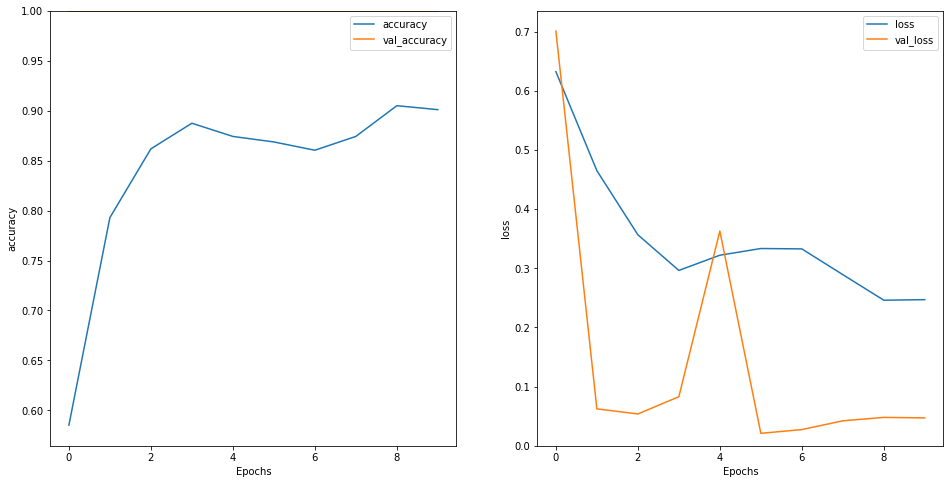

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)